In [1]:
# install pytorch
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


# PyTorch's computation graphs and automatic differentiation

## Creating a graph in PyTorch
a, b, and c will be defined as Tensors.

In [2]:
# define a function with a, b, and c as tensors
import torch
def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [3]:
# call function with tensor objects as function arguments
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))

Scalar Inputs: tensor(1)


In [4]:
print('Rank 1 Inputs:', compute_z(torch.tensor(1), torch.tensor([2]), torch.tensor([3])))

Rank 1 Inputs: tensor([1])


In [5]:
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Rank 2 Inputs: tensor([[1]])


## PyTorch tensor objects for storing and updating model parameters
In PyTorch, a special tensor object for which gradients need to be computed allows us to store and update parameters of model during training.

In [6]:
# generate tensor objects of type=float32
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [7]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


Note that requires_grad is ALWAYS set to False by default.

Tensors can also be created with Glorot initialization, which is a classic random initialization scheme. It is done by first creating an empty tensor then filling it with values according to the Glorot initialization by calling xavier_normal_() method.

In [8]:
# initialize a tensor of shape 2x3 using Glorot initialization
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


<ipython-input-8-707e4720a9c6>:5: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(w)


In [9]:
# define two tensor objects inside the base nn.-Module class
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

These two tensors can then be used as weights whose gradients will be computed via automatic differentiation.

## Computing gradients via automatic differentiation

Used to efficiently compute the gradients of a function and helps optimize neural network models.

### Computing the gradients of the loss with respect to trainable variables
Automatic differentiation is a technique used to efficiently and accurately evaluate the derivatives of a function.
Below is an example where z = wx + b will be computed and the loss will be defined as the squared loss between target y and prediction z.

Loss = (y-z)^2

In [10]:
# implement z = wx + b computation
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [11]:
# verifying the computed gradient
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


In order to verify b, simply rearrange the equation in terms of b.

# Simplifying implementations of common architectures via the torch.nn module

## Implementing models based on nn.Sequential

In [12]:
# build a model with two fully connected layers
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

As seen, the output of the first fully connected layer is used as the input to the first ReLU layer. The output of the first ReLU layer becomes the input for the second fully connected layer. Finally, the output of the second fully connected layer is used as the input to the second ReLU layer.

These layers can be configured further by applying different activation functions, initializers, or regularization methods to the parameters.

In [13]:
# specify the initial value distribution for the weights
nn.init.xavier_uniform(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

<ipython-input-13-6df2238eb871>:2: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(model[0].weight)


Above, the weight of the first linear layer was initialized with Xavier initialization. The L1 norm of the weight was computed for the second linear layer.

## Choosing a loss function
A loss function measures how well a machine learning model is perform with respect to the expected output. Some examples of loss functions include:
- MSE: measures average squared difference between predicted and actual values, used for regression problems 
- Binary cross-entropy: probability between 0 and 1 that measures the difference between the predicted probability and the true label, used for binary classification problems
- Categorical cross-entropy: measures the difference between the predicted probability distribution and the true label, used for multi-class classification problems
- Hinge loss: measures the difference between the predicted score and the true label, used for SVM classification problems

Because this example is a binary classification problem, cross-entropy will be used.

In [14]:
# use SGD optimizer and cross-entropy loss 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Solving an XOR classification problem
A binary classification task where the input data consists of two binary features (x1, x2) and the output is a binary label y that is 1 if exactly one of the input features is 1, and 0 otherwise. 

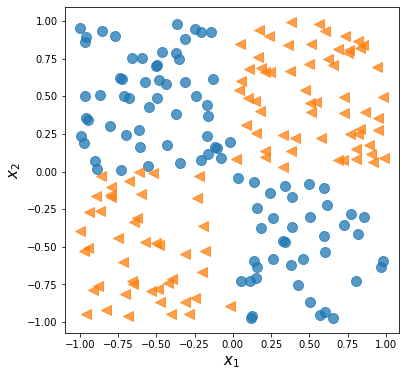

In [15]:
# use half of the data for training and validation
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

The more layers present and the more neurons per layer, the larger the capacity of the model will be.

In [16]:
# create a single-layer NN for linear regression
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [17]:
# initialize cross-entropy loss function and SGD optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [18]:
# create a data loader that uses a batch size of 2 for train data
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [19]:
# train the model for 200 epochs
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

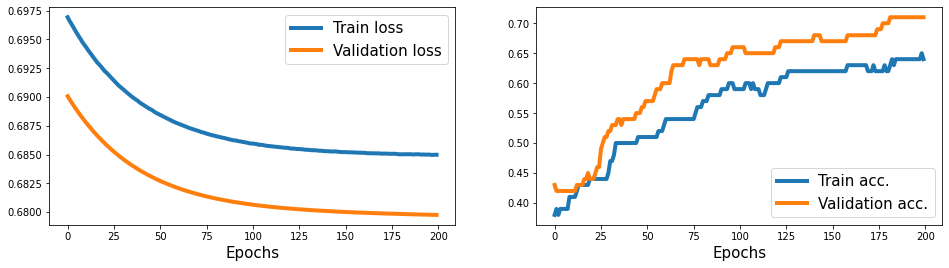

In [20]:
# plot training performance
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

## Making model building more flexible with nn.Module
Provides a way to organize the model's parameters and operations. IT serves as a base class for all neural network modules in PyTorch and provides a convenient way to define complex models. It works because nn.Module allows different layers to be combined easily which can help create complex modules.

In [21]:
# implement previous module with nn.Module
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
        
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return (x)
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [22]:
# train model
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [23]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Besides train history, the mlxtend library can be used to visualize the validation data and the decision boundary.

In [24]:
# install mlxtend
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [25]:
# add predict() method in MyModule class to compute decision boundary
def predict(self, x):
    x = torch.tensor(x, dtype=torch.float32)
    pred = self.forward(x)[:, 0]
    return (pred>=0.5).float()

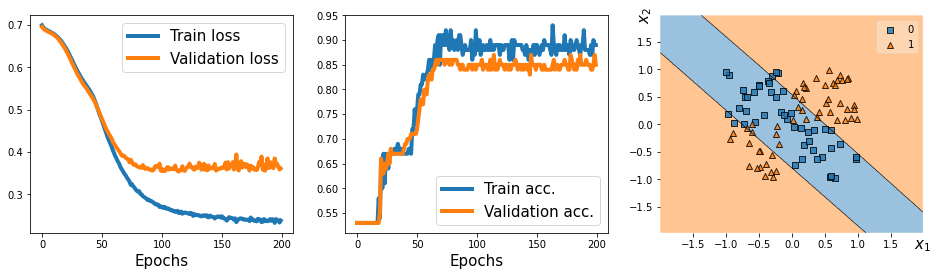

In [26]:
# plot training performance along with decision region bias
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## Writing custom layers in PyTorch
It is useful to define a new class derived from the nn.Module class when designing a new layer or customizing an existing layer. From there, custom layers can provide flexibility and also enables creating models tailored to specific needs.

In [27]:
# define a new layer NoisyLinear implementing w(x+e)+b
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size,
                noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w) # nn.Parameter is a Tensor that is a module parameter
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev
        
    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [28]:
# define a new instance of this layer and execut it on an input tensor
# then, call the layer three times on the same input tensor
torch.manual_seed(1)
noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)


In [29]:
print(noisy_layer(x, training=True))

tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)


In [30]:
print(noisy_layer(x, training=False))

tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [31]:
# create a new model similar to XOR classification
# this time NoisyLinear layer will be used as the first hidden layer
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()
    
torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [32]:
# train model
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
    
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

<ipython-input-33-14de188f7e6e>:16: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  y=y_valid.numpy().astype(np.integer),


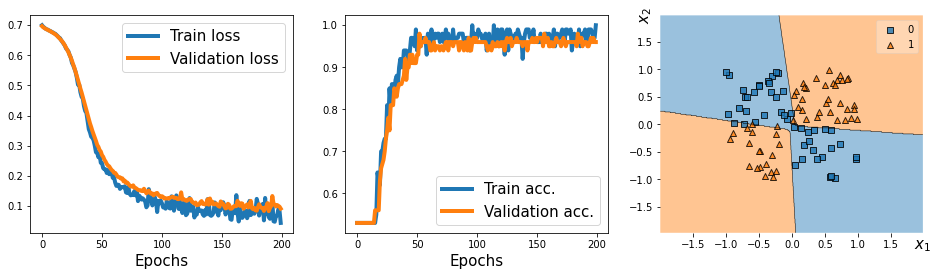

In [33]:
# plot losses, accuracies, and decision boundary
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)
ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(
    X=x_valid.numpy(),
    y=y_valid.numpy().astype(np.integer),
    clf=model
)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()
    


# Project one - predicting the fuel efficiency of a car
Steps in machine learning tasks: data preprocessing, feature engineering, training, prediction, evaluation.

## Working with feature columns

In [34]:
# load data and apply preprocessing steps
# i.e. dropping incomplete rows, splitting data to training/test sets, standardizing continuous features
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [35]:
# drop the NA rows
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [36]:
# split into training/testing sets
import sklearn
import sklearn.model_selection
df_train, df_test = sklearn.model_selection.train_test_split(
df, train_size=0.8, random_state=1
)
train_stats = df_train.describe().transpose()

In [37]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std
    
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


Based on the model year, the cars will be split into groups called buckets. These cutoffs were selected arbitrarily.

In [38]:
# generate indices of the buckets
boundaries = torch.tensor([73, 76, 79])
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [39]:
# use one-hot encoding to convert categorical features to dense format
from torch.nn.functional import one_hot
total_origin = len(set(df_train_norm['Origin']))
origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()
origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [40]:
# create a label tensors from the ground truth MPG values
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_train_norm['MPG'].values).float()

In [41]:
# train a DNN regression model - create a data loader w/ batch size = 8 for train data
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [42]:
# build a model w/ two fully connected layers (8 and 4 hidden units respectively)
hidden_units = [8, 4]
input_size = x_train.shape[1]
all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [43]:
# define the MSE loss function for regression and use SGD for optimization
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [44]:
# train model for 200 epochs and display train loss ever 20 epochs
torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch} Loss '
              f'{loss_hist_train/len(train_dl):.4f}')

Epoch 0 Loss 536.1047
Epoch 20 Loss 8.4361
Epoch 40 Loss 7.8695
Epoch 60 Loss 7.1891
Epoch 80 Loss 6.7062
Epoch 100 Loss 6.7599
Epoch 120 Loss 6.3124
Epoch 140 Loss 6.6864
Epoch 160 Loss 6.7648
Epoch 180 Loss 6.2156


As seen, after 200 epochs, the train loss was around 5.

# Higher-level PyTorch APIs: a short introduction to PyTorch-Lightning
PyTorch Lightning is a widely used PyTorch library that makes training deep neural networks simpler by removing much of the boilerplate code. However, while Lightning's focus lies in simplicity and flexibility, it also allows us to use many advaced features (i.e. multi-GPU support, fast low-precision training).

## Setting up the PyTorch Lightning model

In [45]:
# install pytorch lightning
!pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [46]:
# implement pytorch lightning model 
import pytorch_lightning as pl
import torch
import torch.nn as nn
from torchmetrics import Accuracy

In [52]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        
        # new PL attributes:
        self.train_acc = Accuracy()
        self.valid_acc = Accuracy()
        self.test_acc = Accuracy()
        
        # Model similar to previous section:
        input_size = image_shape[0] * image_shape[1] * image_shape[2] 
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units: 
            layer = nn.Linear(input_size, hidden_unit) 
            all_layers.append(layer) 
            all_layers.append(nn.ReLU()) 
            input_size = hidden_unit 
 
        all_layers.append(nn.Linear(hidden_units[-1], 10)) 
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def training_epoch_end(self, outs):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

The __init__ constructor contains the same model code used from the previous section. However, the accuracy attributes such as self.train_acc = Accuracy() were added which allows easy tracking of accuracy during training. 

The forward method implements a simple forward pass that returns the logits (outputs of the last fully connected layer of the network before softmax layer). The logits are computed via the forward method by calling self(x) which will be used for training, validation, and test sets.

The training_step, training_epoch_end are methods that are specific to Lightning. training_step defines a single forward pass that also keeps track of accuracy and loss. The training_step is also executed on each individual batch during training, and via the training_epoch_end method, which is executed at the end of each training epoch.

The validation_step and test_step methods define how the validation and test evaluation process should be computed. Each validation_step and test_step receives a single batch, which is why the accuracy is logged via respective accuracy attributes. However, it is important to note that the validation_step is only called after each training epoch. This is why the validation accuracy is logged inside the validation step, whereas with the training accuracy, it is logged after each training epoch. 

Finally, with the configure_optimizers method, the optimizer (Adam) is specified for training.

## Setting up the data loaders for Lightning
Here, LightningDataModule will be used where it consists of five main methods.

In [53]:
# setting up the data loaders
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision.datasets import MNIST
from torchvision import transforms

In [54]:
# implement lightningdatamodule
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        MNIST(root=self.data_path, download=True) 

    def setup(self, stage=None):
        # stage is either 'fit', 'validate', 'test', or 'predict'
        # here note relevant
        mnist_all = MNIST( 
            root=self.data_path,
            train=True,
            transform=self.transform,  
            download=False
        ) 

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST( 
            root=self.data_path,
            train=False,
            transform=self.transform,  
            download=False
        ) 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4)
    
    
torch.manual_seed(1) 
mnist_dm = MnistDataModule()

In the prepare_data method, several steps were defined (i.e. downloading the dataset).
In the setup method, the datasets used for training, validation, and testing are defined.

## Training the model using the PyTorch Lightning Trainer class

In [55]:
from pytorch_lightning.callbacks import ModelCheckpoint


mnistclassifier = MultiLayerPerceptron()

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

trainer = pl.Trainer(max_epochs=10, callbacks=callbacks)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

TypeError: __new__() missing 1 required positional argument: 'task'

## Evaluating the model using TensorBoard

In [56]:
# install tensorboard
!pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
  Using cached MarkupSafe-2.1.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytorch-lightning 2.0.1 requires PyYAML>=5.4, but you'll have pyyaml 5.3.1 which is incompatible.
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [58]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [59]:
path = 'lightning_logs/version_0/checkpoints/epoch=8-step=7739.ckpt'

In [61]:
from pytorch_lightning.callbacks import ModelCheckpoint
callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

trainer = pl.Trainer(max_epochs=15, callbacks=callbacks, resume_from_checkpoint=path)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

TypeError: __init__() got an unexpected keyword argument 'resume_from_checkpoint'